## HICP Data Analysis

The file `HICPSpain.xlsx` stores the time series of the Harmonised Indices of Consumer Prices (HICP) in Spain from Q1 1996 to Q4 2022. The following code loads the data and creates the time series plot.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Load dataset
file_path = "HICPSpain.xlsx"
df = pd.read_excel(file_path)

In [3]:
# Convert 'Date' to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Extract year and quarter
df["Quarter"] = df["Date"].dt.to_period("Q").astype(str)


print(df.head())

        Date  HICP.All.Spain Quarter
0 1996-01-01           64.34  1996Q1
1 1996-04-01           64.93  1996Q2
2 1996-07-01           65.38  1996Q3
3 1996-10-01           65.64  1996Q4
4 1997-01-01           65.77  1997Q1


In [4]:
df.set_index("Quarter", inplace=True)


In [5]:
print(df)

              Date  HICP.All.Spain
Quarter                           
1996Q1  1996-01-01           64.34
1996Q2  1996-04-01           64.93
1996Q3  1996-07-01           65.38
1996Q4  1996-10-01           65.64
1997Q1  1997-01-01           65.77
...            ...             ...
2021Q4  2021-10-01          111.13
2022Q1  2022-01-01          115.51
2022Q2  2022-04-01          118.22
2022Q3  2022-07-01          117.55
2022Q4  2022-10-01          117.22

[108 rows x 2 columns]


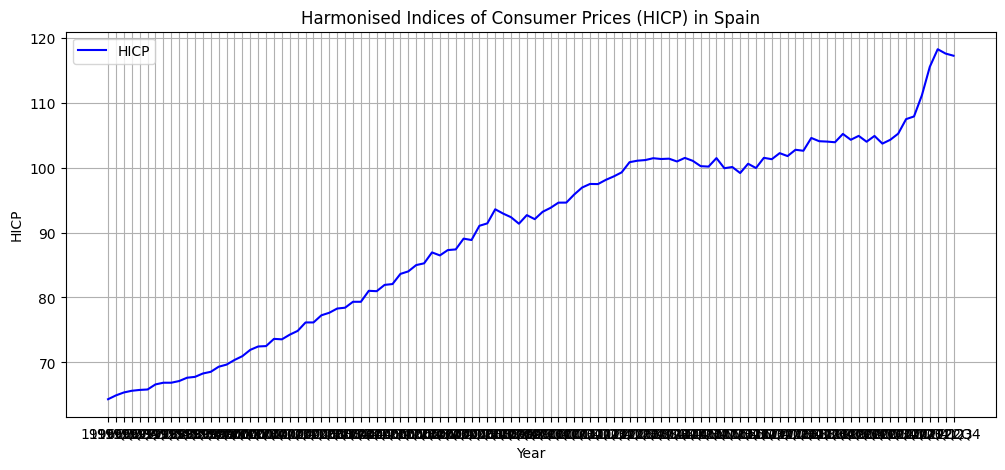

In [6]:
#  Plot Full Time Series ---
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["HICP.All.Spain"], color="blue", label="HICP")
plt.title("Harmonised Indices of Consumer Prices (HICP) in Spain")
plt.xlabel("Year")
plt.ylabel("HICP")
plt.legend()
plt.grid()
plt.show()

<Figure size 1200x500 with 0 Axes>

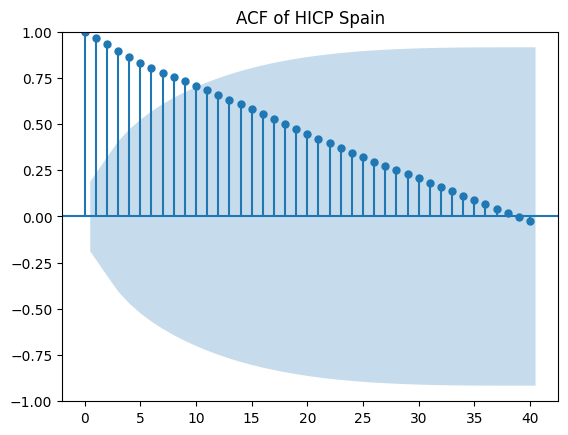

In [7]:
# Plot the ACF of the time series
plt.figure(figsize=(12, 5))
plot_acf(df["HICP.All.Spain"], lags=40)
plt.title("ACF of HICP Spain")
plt.show()

The following code creates the decompositions of the time series into their trend, seasonal and residual components under the additive and multiplicative model. We set `period=4` since we have quarterly data. 

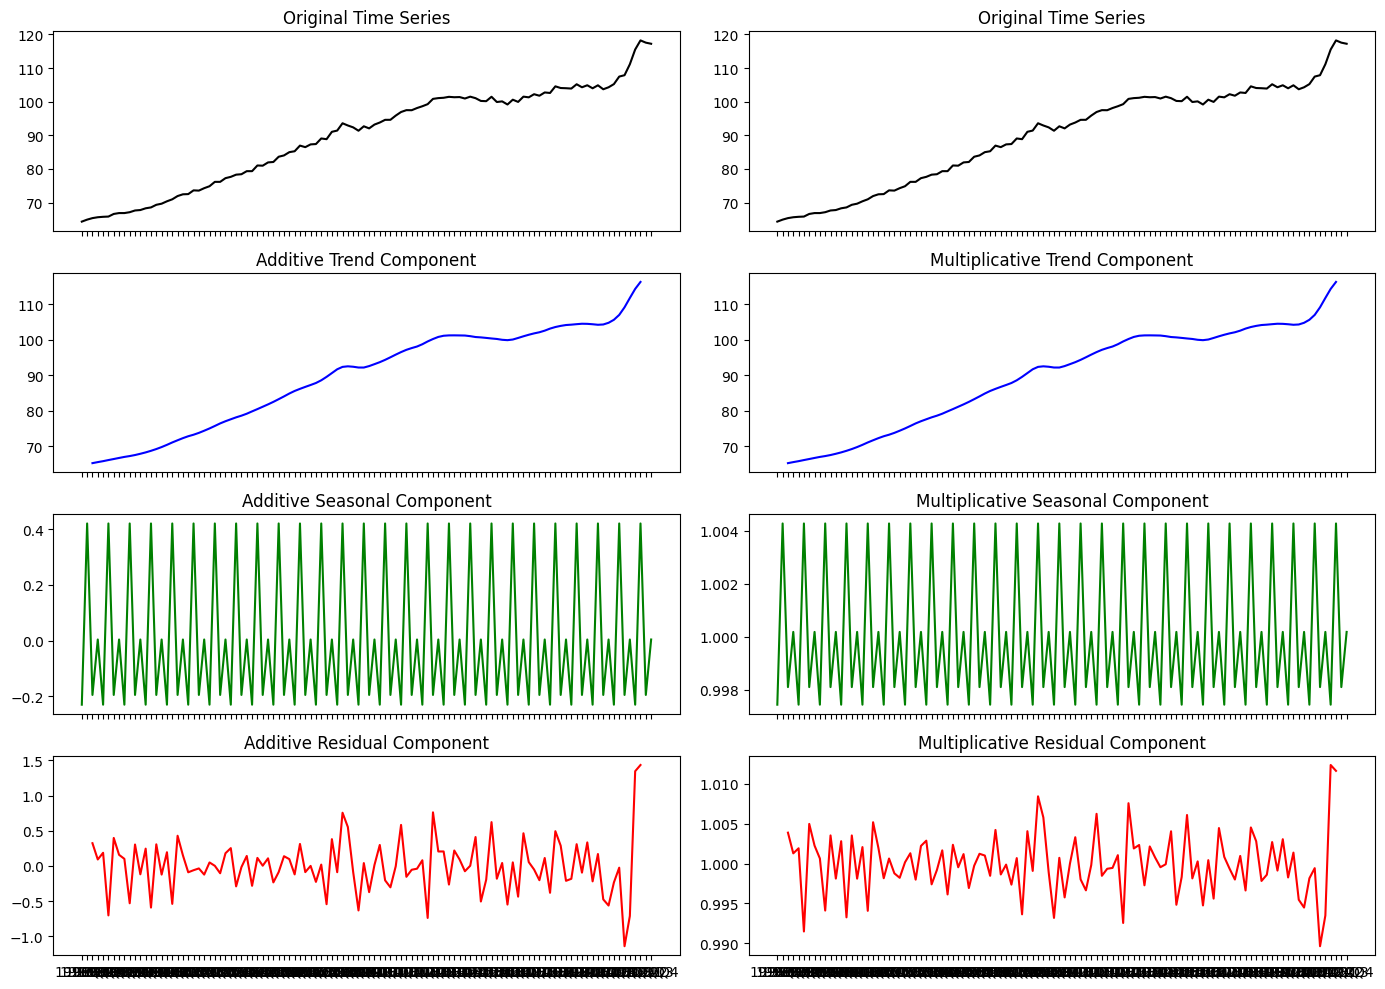

In [8]:

# ---  Apply Additive and Multiplicative Decomposition ---
additive_decomposition = seasonal_decompose(df["HICP.All.Spain"], model="additive", period=4)
multiplicative_decomposition = seasonal_decompose(df["HICP.All.Spain"], model="multiplicative", period=4)

# Plot both decompositions side by side
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

# Additive Decomposition Plots
axes[0, 0].plot(df.index, df["HICP.All.Spain"], color="black")
axes[0, 0].set_title("Original Time Series")

axes[1, 0].plot(df.index, additive_decomposition.trend, color="blue")
axes[1, 0].set_title("Additive Trend Component")

axes[2, 0].plot(df.index, additive_decomposition.seasonal, color="green")
axes[2, 0].set_title("Additive Seasonal Component")

axes[3, 0].plot(df.index, additive_decomposition.resid, color="red")
axes[3, 0].set_title("Additive Residual Component")

# Multiplicative Decomposition Plots
axes[0, 1].plot(df.index, df["HICP.All.Spain"], color="black")
axes[0, 1].set_title("Original Time Series")

axes[1, 1].plot(df.index, multiplicative_decomposition.trend, color="blue")
axes[1, 1].set_title("Multiplicative Trend Component")

axes[2, 1].plot(df.index, multiplicative_decomposition.seasonal, color="green")
axes[2, 1].set_title("Multiplicative Seasonal Component")

axes[3, 1].plot(df.index, multiplicative_decomposition.resid, color="red")
axes[3, 1].set_title("Multiplicative Residual Component")

plt.tight_layout()
plt.show()


We next ask ourselves if the residuals of the additive decomposition are stationary. If not, it means that there are additional patterns in the data that the decomposition did not pick up. What does the p-value tell us?

In [9]:
# --- Perform ADF Test on Residuals (Assuming Additive is Best) ---
residuals = additive_decomposition.resid.dropna()
adf_result = adfuller(residuals)

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")


ADF Statistic: -6.5203
p-value: 0.0000


We also compute the ACF and PACF to check if the residuals are white noise (the ACF would be sufficient, this is to show you how to compute the PACF). What do we observe?

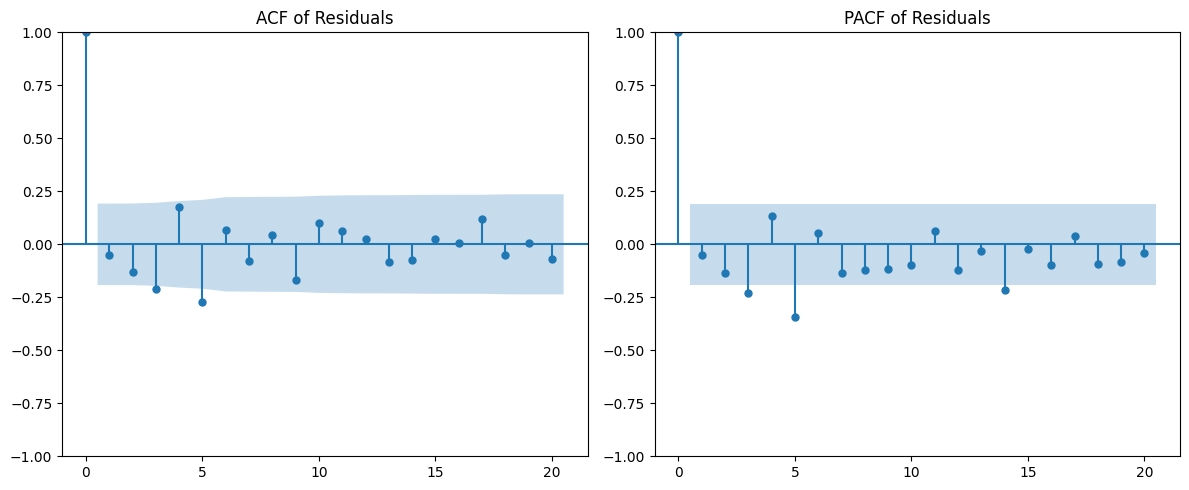

In [10]:
# ---  ACF and PACF Plots of Residuals ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF plot
plot_acf(residuals, lags=20, ax=axes[0])
axes[0].set_title("ACF of Residuals")

# PACF plot
plot_pacf(residuals, lags=20, ax=axes[1])
axes[1].set_title("PACF of Residuals")

plt.tight_layout()
plt.show()


Last, we use the Ljung-Box test, checking if the first 20 autocorrelations are all zero. What does the p-value tell us?

In [11]:
# --- Perform Ljung-Box Test ---
ljungbox_result = acorr_ljungbox(residuals, lags=[20], return_df=True)
p_value_ljungbox = ljungbox_result["lb_pvalue"].values[0]

print(f"Ljung-Box p-value: {p_value_ljungbox:.4f}")



Ljung-Box p-value: 0.0782


## AR Model

In [12]:
df["HICP_diff"] = df["HICP.All.Spain"].diff()

In [13]:
df = df.dropna()
print(df)

              Date  HICP.All.Spain  HICP_diff
Quarter                                      
1996Q2  1996-04-01           64.93       0.59
1996Q3  1996-07-01           65.38       0.45
1996Q4  1996-10-01           65.64       0.26
1997Q1  1997-01-01           65.77       0.13
1997Q2  1997-04-01           65.84       0.07
...            ...             ...        ...
2021Q4  2021-10-01          111.13       3.26
2022Q1  2022-01-01          115.51       4.38
2022Q2  2022-04-01          118.22       2.71
2022Q3  2022-07-01          117.55      -0.67
2022Q4  2022-10-01          117.22      -0.33

[107 rows x 3 columns]


In [14]:
# Fit an AR(1) model (i.e., ARIMA(1, 0, 0))
ar1_model = sm.tsa.ARIMA(df["HICP_diff"], order=(1, 0, 0)).fit()


# Print the model summary
print(ar1_model.summary())

                               SARIMAX Results                                
Dep. Variable:              HICP_diff   No. Observations:                  107
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -141.978
Date:                Wed, 05 Mar 2025   AIC                            289.957
Time:                        18:13:04   BIC                            297.975
Sample:                    04-01-1996   HQIC                           293.207
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4943      0.100      4.958      0.000       0.299       0.690
ar.L1         -0.0180      0.072     -0.248      0.804      -0.160       0.124
sigma2         0.8319      0.101      8.211      0.0

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

<Figure size 1200x500 with 0 Axes>

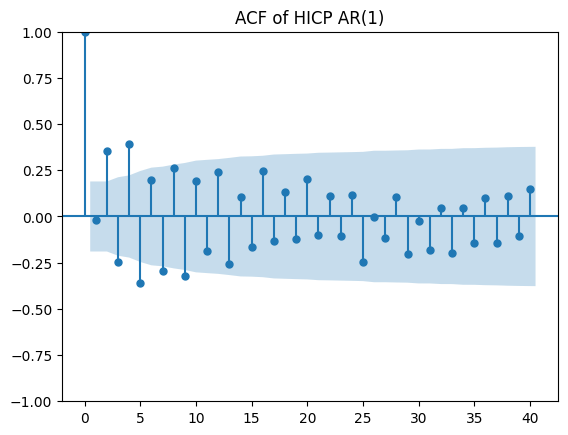

In [15]:
# Plot the ACF of AR(1)
plt.figure(figsize=(12, 5))
plot_acf(df['HICP_diff'], lags=40)
plt.title("ACF of HICP AR(1)")
plt.show()

<Figure size 1200x500 with 0 Axes>

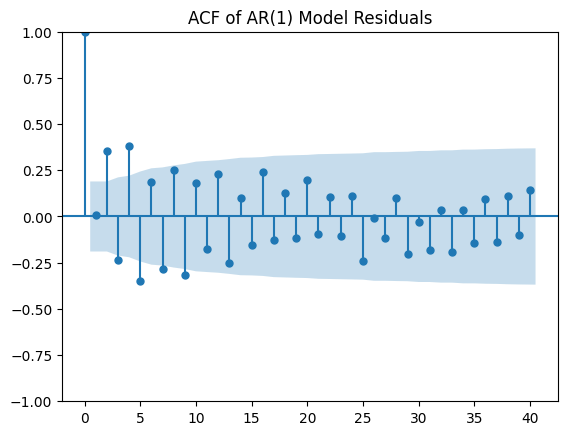

In [16]:
# Get residuals from the AR(1) model
residuals = ar1_model.resid

# Plot ACF of residuals
plt.figure(figsize=(12,5))
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title("ACF of AR(1) Model Residuals")
plt.show()

In [17]:
ljung_box_results = acorr_ljungbox(residuals, lags=[20], return_df=True)
p_value_ljungbox = ljung_box_results["lb_pvalue"].values[0]

print(f"Ljung-Box p-value: {p_value_ljungbox:.4f}")


Ljung-Box p-value: 0.0000


In [18]:
# List to store results for each AR(p) model
results = []

# Fit AR(p) models for p = 1 to 10 and record AIC and BIC
for p in range(1, 21):
    model = ARIMA(df['HICP.All.Spain'], order=(p, 0, 0))
    res = model.fit()
    results.append({'p': p, 'AIC': res.aic, 'BIC': res.bic})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Display the table of AIC and BIC values
print(results_df)

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

     p         AIC         BIC
0    1  324.583434  332.601921
1    2  321.685684  332.376999
2    3  295.405865  308.770009
3    4  293.273200  309.310173
4    5  273.881336  292.591137
5    6  266.205955  287.588586
6    7  266.742380  290.797840
7    8  267.888263  294.616551
8    9  268.586755  297.987872
9   10  270.504830  302.578776
10  11  272.391135  307.137910
11  12  268.805457  306.225060
12  13  270.540917  310.633350
13  14  272.532829  315.298090
14  15  273.641348  319.079438
15  16  273.415453  321.526372
16  17  273.760730  324.544478
17  18  269.495631  322.952207
18  19  277.171398  333.300803
19  20  278.833079  337.635314


/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
# List to store results for each MA(p) model
results = []

# Fit MA(p) models for p = 1 to 20 and record AIC and BIC
for p in range(1, 21):
    model = ARIMA(df['HICP.All.Spain'], order=(0, 0, p))
    res = model.fit()
    results.append({'p': p, 'AIC': res.aic, 'BIC': res.bic})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Display the table of AIC and BIC values
print(results_df)

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

     p         AIC         BIC
0    1  756.791434  764.809921
1    2  626.963437  637.654753
2    3  566.745400  580.109544
3    4  497.298697  513.335670
4    5  491.619910  510.329712
5    6  412.249663  433.632293
6    7  405.703762  429.759221
7    8  374.608274  401.336562
8    9  347.007517  376.408635
9   10  328.132336  360.206282
10  11  328.609149  363.355924
11  12  315.118577  352.538180
12  13  316.192809  356.285241
13  14  304.331993  347.097254
14  15  315.585459  361.023549
15  16  293.874600  341.985519
16  17  296.733588  347.517335
17  18  541.559085  595.015662
18  19  304.701215  360.830621
19  20  292.945513  351.747747


/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### AR(6) model

In [20]:
ar6_model = sm.tsa.ARIMA(df["HICP_diff"], order=(6, 0, 0)).fit()


# Print the model summary
print(ar6_model.summary())

                               SARIMAX Results                                
Dep. Variable:              HICP_diff   No. Observations:                  107
Model:                 ARIMA(6, 0, 0)   Log Likelihood                -114.586
Date:                Wed, 05 Mar 2025   AIC                            245.173
Time:                        18:13:33   BIC                            266.556
Sample:                    04-01-1996   HQIC                           253.841
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4714      0.106      4.428      0.000       0.263       0.680
ar.L1          0.3403      0.128      2.651      0.008       0.089       0.592
ar.L2          0.1144      0.095      1.204      0.2

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

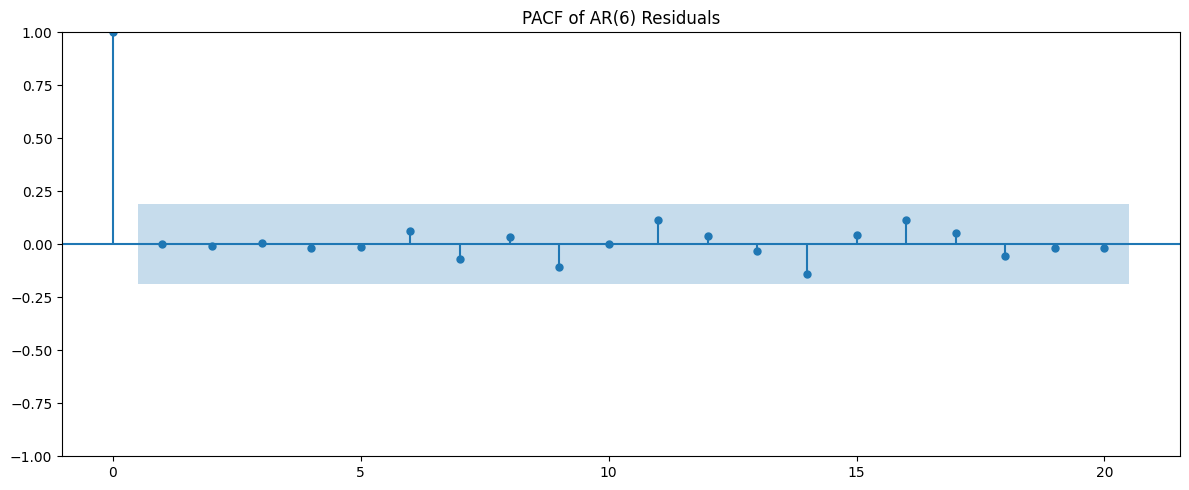

In [21]:
# Get residuals from the AR(6) model
fig, axes = plt.subplots(figsize=(12, 5))
residuals = ar6_model.resid
plot_pacf(residuals, lags=20, ax=axes)
axes.set_title("PACF of AR(6) Residuals")
plt.tight_layout()
plt.show()


/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

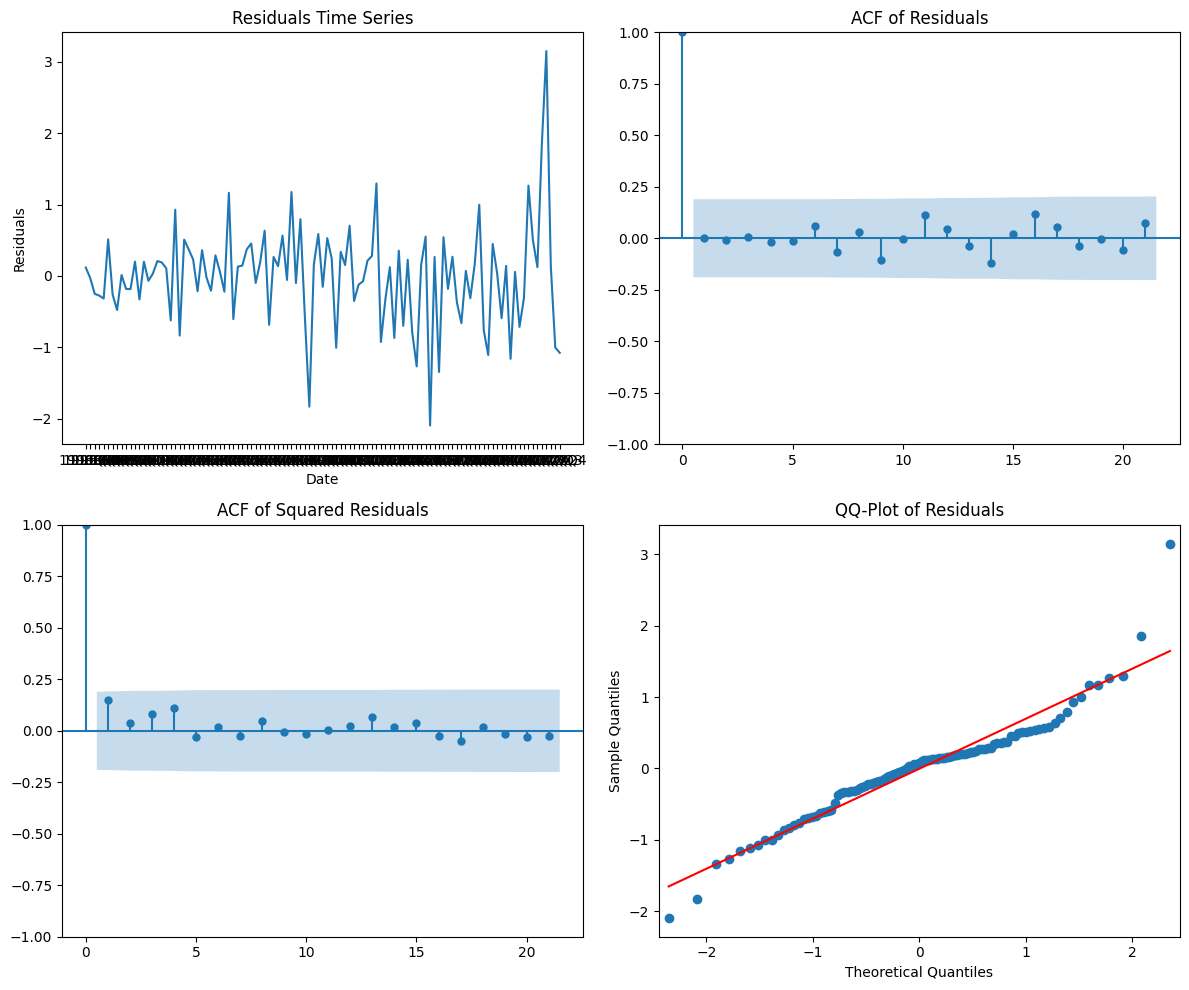

In [22]:
model = ARIMA(df['HICP_diff'], order=(6, 0, 0))
results = model.fit()
resid = results.resid

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Time series plot of the residuals
axes[0, 0].plot(resid)
axes[0, 0].set_title("Residuals Time Series")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Residuals")

# 2. ACF plot of the residuals
plot_acf(resid, ax=axes[0, 1])
axes[0, 1].set_title("ACF of Residuals")

# 3. ACF plot of the squared residuals
plot_acf(resid**2, ax=axes[1, 0])
axes[1, 0].set_title("ACF of Squared Residuals")

# 4. QQ-plot of the residuals
sm.qqplot(resid, line='s', ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()

### MA(12) model

In [23]:
ma12_model = sm.tsa.ARIMA(df["HICP_diff"], order=(0, 0, 12)).fit()


# Print the model summary
print(ma12_model.summary())

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

                               SARIMAX Results                                
Dep. Variable:              HICP_diff   No. Observations:                  107
Model:                ARIMA(0, 0, 12)   Log Likelihood                -111.766
Date:                Wed, 05 Mar 2025   AIC                            251.532
Time:                        18:13:35   BIC                            288.952
Sample:                    04-01-1996   HQIC                           266.702
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4770      0.127      3.757      0.000       0.228       0.726
ma.L1          0.2754      0.124      2.222      0.026       0.032       0.518
ma.L2          0.3191      0.183      1.741      0.0

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


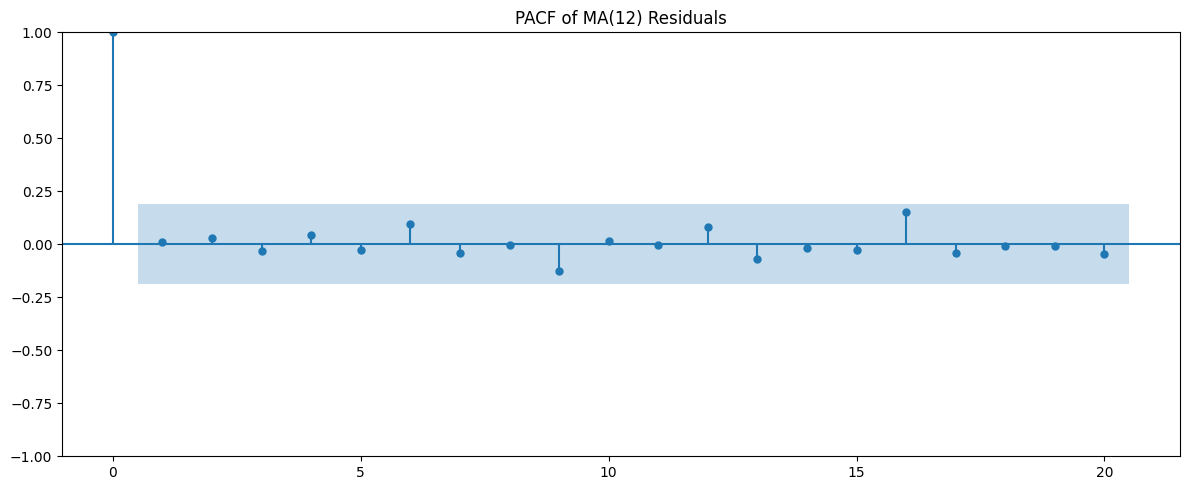

In [24]:
# Get residuals from the MA(12) model
fig, axes = plt.subplots(figsize=(12, 5))
residuals = ma12_model.resid
plot_pacf(residuals, lags=20, ax=axes)
axes.set_title("PACF of MA(12) Residuals")
plt.tight_layout()
plt.show()

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

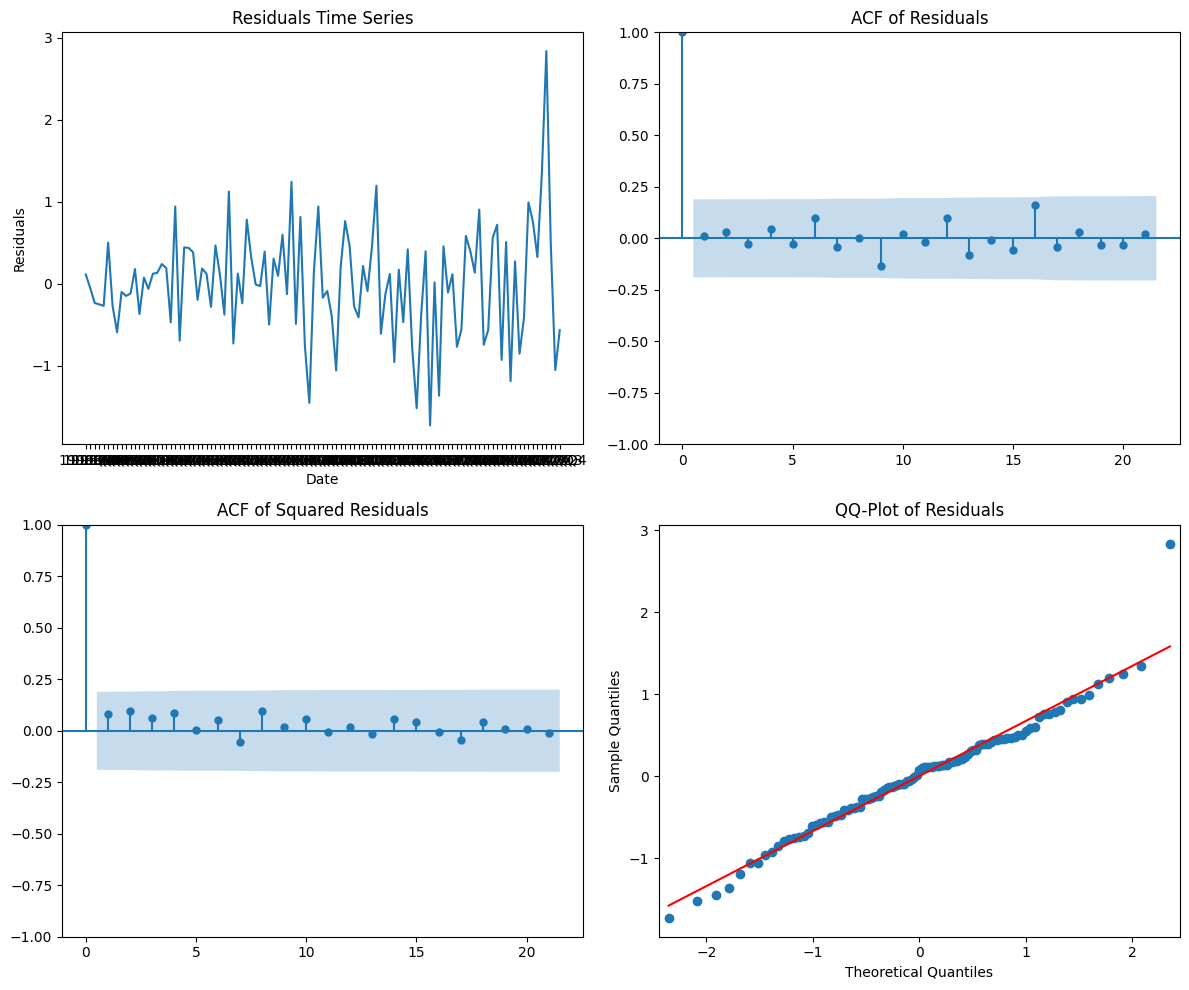

In [25]:
model = ARIMA(df['HICP_diff'], order=(0, 0, 12))
results = model.fit()
resid = results.resid

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Time series plot of the residuals
axes[0, 0].plot(resid)
axes[0, 0].set_title("Residuals Time Series")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Residuals")

# 2. ACF plot of the residuals
plot_acf(resid, ax=axes[0, 1])
axes[0, 1].set_title("ACF of Residuals")

# 3. ACF plot of the squared residuals
plot_acf(resid**2, ax=axes[1, 0])
axes[1, 0].set_title("ACF of Squared Residuals")

# 4. QQ-plot of the residuals
sm.qqplot(resid, line='s', ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()

## ARIMA 5 Year Prediction

In [26]:
df.index = pd.PeriodIndex(df.index.astype(str), freq="Q")


In [27]:
train = df[df.index < pd.Period("2015Q1", freq="Q")]  # Training set: before 2015
test = df[(df.index >= pd.Period("2015Q1", freq="Q")) & (df.index <= pd.Period("2019Q4", freq="Q"))]  # Test set: 2015-2020
train_plot = df[(df.index >= pd.Period("2010Q1", freq="Q")) & (df.index <= pd.Period("2019Q4", freq="Q"))]  # Data for plotting: 2010-2020

In [28]:
# Fit an AR(6) model on the training data
model = ARIMA(train['HICP_diff'], order=(6, 0, 12))
results = model.fit()
print(results.summary())

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:              HICP_diff   No. Observations:                   75
Model:                ARIMA(6, 0, 12)   Log Likelihood                 -51.457
Date:                Wed, 05 Mar 2025   AIC                            142.915
Time:                        18:13:38   BIC                            189.265
Sample:                    06-30-1996   HQIC                           161.422
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4234      0.194      2.177      0.029       0.042       0.804
ar.L1          0.0609      0.558      0.109      0.913      -1.032       1.154
ar.L2          0.0909      0.598      0.152      0.8

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


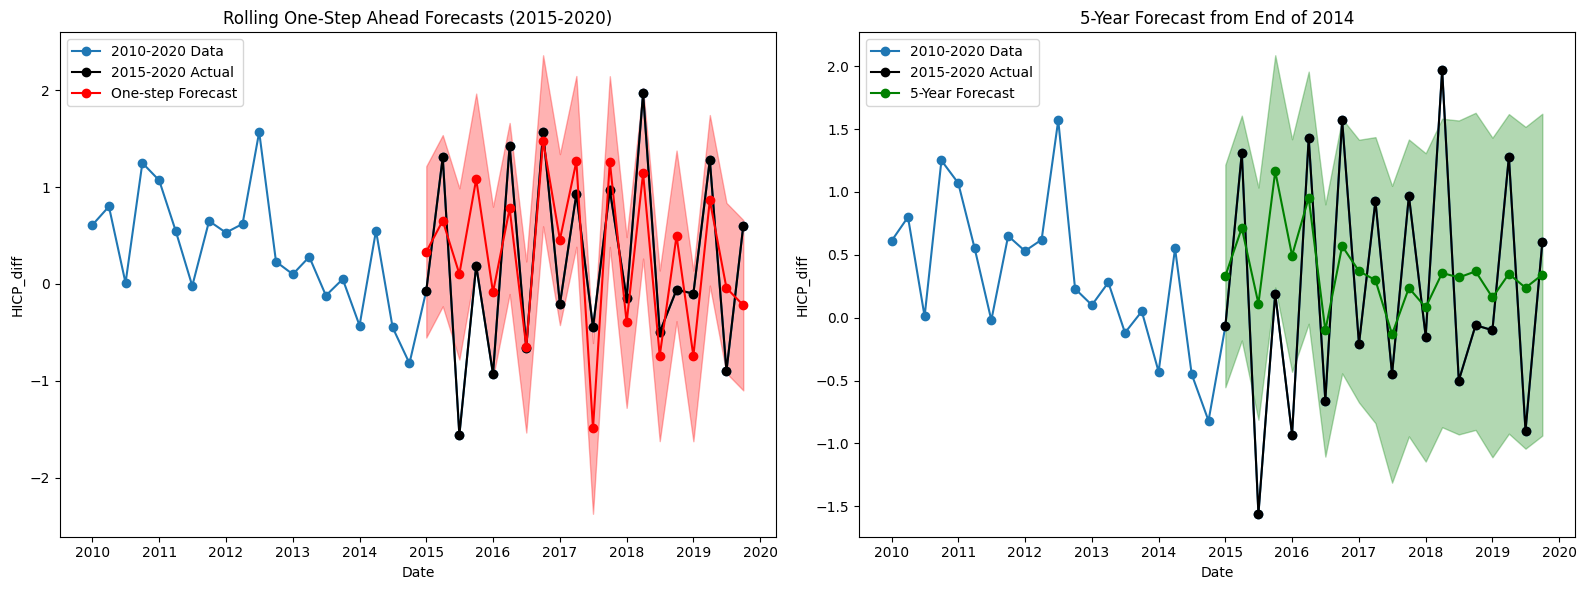

In [29]:
# 5-year forecast from the end of 2014 (static forecast)
forecast_res = results.get_forecast(steps=20)  # 20 quarters = 5 years
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# Rolling one-step ahead forecasts for 2015-2020 using the .append() method.
current_results = results  # Use the fitted results directly
one_step_forecasts = []
one_step_ci_lower = []
one_step_ci_upper = []

for date in test.index:
    # Forecast one step ahead using the current state of the model
    forecast_obj = current_results.get_forecast(steps=1)
    forecast_value = forecast_obj.predicted_mean.iloc[0]
    ci = forecast_obj.conf_int()
    one_step_forecasts.append(forecast_value)
    one_step_ci_lower.append(ci.iloc[0, 0])
    one_step_ci_upper.append(ci.iloc[0, 1])

    # Ensure the test data being appended maintains the same format as train
    new_obs = test.loc[[date], ['HICP_diff']].copy()  # Select only the necessary column
    new_obs.index = pd.PeriodIndex(new_obs.index.astype(str), freq="Q")  # Ensure correct freq
    current_results = current_results.append(new_obs, refit=False)  # Append only relevant column

# Convert forecast lists to Series with same index as test
one_step_forecasts = pd.Series(one_step_forecasts, index=test.index)
one_step_ci_lower = pd.Series(one_step_ci_lower, index=test.index)
one_step_ci_upper = pd.Series(one_step_ci_upper, index=test.index)

# Convert PeriodIndex to DatetimeIndex for plotting
train_plot.index = train_plot.index.to_timestamp()
test.index = test.index.to_timestamp()
one_step_forecasts.index = one_step_forecasts.index.to_timestamp()
forecast_mean.index = forecast_mean.index.to_timestamp()
forecast_ci.index = forecast_ci.index.to_timestamp()

# Create two side-by-side plots (showing only 2015-2020 on x-axis)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Rolling one-step ahead forecasts for 2015-2020
axes[0].plot(train_plot.index, train_plot['HICP_diff'], label='2010-2020 Data', marker='o')
axes[0].plot(test.index, test['HICP_diff'], label='2015-2020 Actual', color='black', marker='o')
axes[0].plot(one_step_forecasts.index, one_step_forecasts, label='One-step Forecast', color='red', marker='o')
axes[0].fill_between(one_step_forecasts.index, one_step_ci_lower, one_step_ci_upper, color='red', alpha=0.3)
axes[0].set_title("Rolling One-Step Ahead Forecasts (2015-2020)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("HICP_diff")
axes[0].legend()

# Right plot: 5-year ahead forecast from the end of 2014
axes[1].plot(train_plot.index, train_plot['HICP_diff'], label='2010-2020 Data', marker='o')
axes[1].plot(test.index, test['HICP_diff'], label='2015-2020 Actual', color='black', marker='o')
axes[1].plot(forecast_mean.index, forecast_mean, label='5-Year Forecast', color='green', marker='o')
axes[1].fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
axes[1].set_title("5-Year Forecast from End of 2014")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("HICP_diff")
axes[1].legend()

plt.tight_layout()
plt.show()

/var/folders/qw/zy6hh4gn3636nhytvp50x6r80000gn/T/ipykernel_34548/3279346119.py:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_mean.index = pd.date_range(start=overlap_start + pd.DateOffset(months=3),


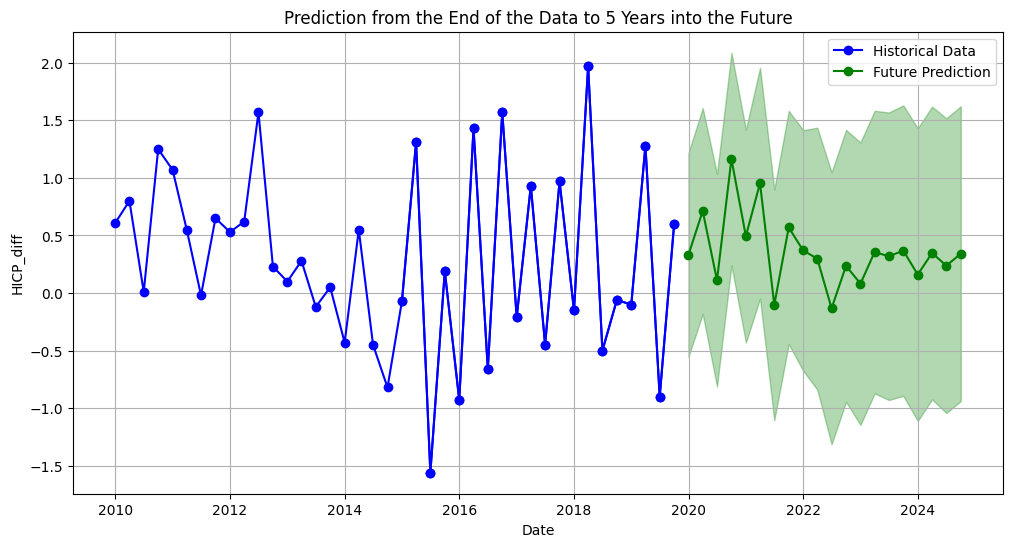

In [30]:
# Define the number of steps for the future prediction
forecast_steps = 20  # 20 quarters = 5 years

# Last available date in historical data
overlap_start = test.index[-2]  # Last date in the test dataset

# Generate forecast from the last data point to 5 years into the future
future_forecast = results.get_forecast(steps=forecast_steps)
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

# Adjust the prediction index to start right after the last data point
future_mean.index = pd.date_range(start=overlap_start + pd.DateOffset(months=3), 
                                  periods=forecast_steps, freq='Q')
future_ci.index = future_mean.index  # Align confidence intervals

# Create a plot with historical data + future predictions
plt.figure(figsize=(12, 6))

# Plot historical data in blue
plt.plot(train_plot.index, train_plot['HICP_diff'], label='Historical Data', color='blue', marker='o')
plt.plot(test.index, test['HICP_diff'], color='blue', marker='o')

# Plot future prediction in green
plt.plot(future_mean.index, future_mean, label='Future Prediction', color='green', marker='o')
plt.fill_between(future_ci.index, future_ci.iloc[:, 0], future_ci.iloc[:, 1], color='green', alpha=0.3)

# Configure the plot
plt.title("Prediction from the End of the Data to 5 Years into the Future")
plt.xlabel("Date")
plt.ylabel("HICP_diff")
plt.legend()
plt.grid()

plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [32]:
df_clean = df.dropna()
train_data = df_clean.loc[:"2015"]  # Use only 2012-2020 for training

# Set forecast start (beginning of 2020) and extend to 2025
forecast_start = pd.to_datetime("2015-01-01")  # Start forecast from 2020
forecast_end = pd.to_datetime("2021-01-01")  # Forecast until end of 2025
test_data = df_clean.loc[forecast_start:forecast_end]  # Use available data for testing

# Train SARIMA model on 2012-2020 data
model = ARIMA(train['HICP.All.Spain'], order=(6, 1, 12))
results = model.fit()

# Forecast from 2020 to 2025
forecast_values = results.get_forecast(steps=len(test_data))  

# Convert forecasted values to a Pandas Series with the correct index
forecast_series = pd.Series(forecast_values.predicted_mean.values, index=test_data.index)

# Evaluate Forecast Accuracy
mae = mean_absolute_error(test_data["HICP.All.Spain"], forecast_series)
rmse = np.sqrt(mean_squared_error(test_data["HICP.All.Spain"], forecast_series))
mape = np.mean(np.abs((test_data["HICP.All.Spain"] - forecast_series) / test_data["HICP.All.Spain"])) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Absolute Error (MAE): 1.52
Root Mean Squared Error (RMSE): 1.83
Mean Absolute Percentage Error (MAPE): 1.47%


/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Discoveries from ARIMA (6,0,12)
### Rolling One-Step Ahead Forecasts
- The One-step forecast indicates that the model is well updating over time
- Uncertainties increase over time
- Variability in residuals may indicate model limitation
- Good fit for short-term predictionRMSE is relatively small compared to the range of actual values

### 5 Year Forecasts
- Long term prediction aligns with the actual value at beginning but diverges with time
- Wide confidence interval meaning uncertainty increases significantly
- The forecast smoothed out whereas the actual data is volatile
- The model struggles capturing long-term data

### Out-Sample Forecast
- Short term speaking, the model captures the recent votality well
- In long term, the forecast smooths out, possibly underestimating structural inflation changes
- Increasing Uncertainty over time 

### RMSE and MAPE Analysis
- RMSE is relatively small compared to the range of actual values, since it is much smaller than the actual standard deviation, so it captures most of the variability
- MAPE is low which suggests that the forecasts is quite reliable as it deviates from the actual values by 2.26%


## SARIMA Model

The difference of consecutive values and the seasonal difference

In [33]:
seasonal_diff = df["HICP.All.Spain"].diff(4).dropna()

In [34]:
both_diff = df["HICP_diff"].diff(4).dropna()

In [35]:
df.index = df.index.to_timestamp()
seasonal_diff.index = seasonal_diff.index.to_timestamp()
both_diff.index = both_diff.index.to_timestamp()

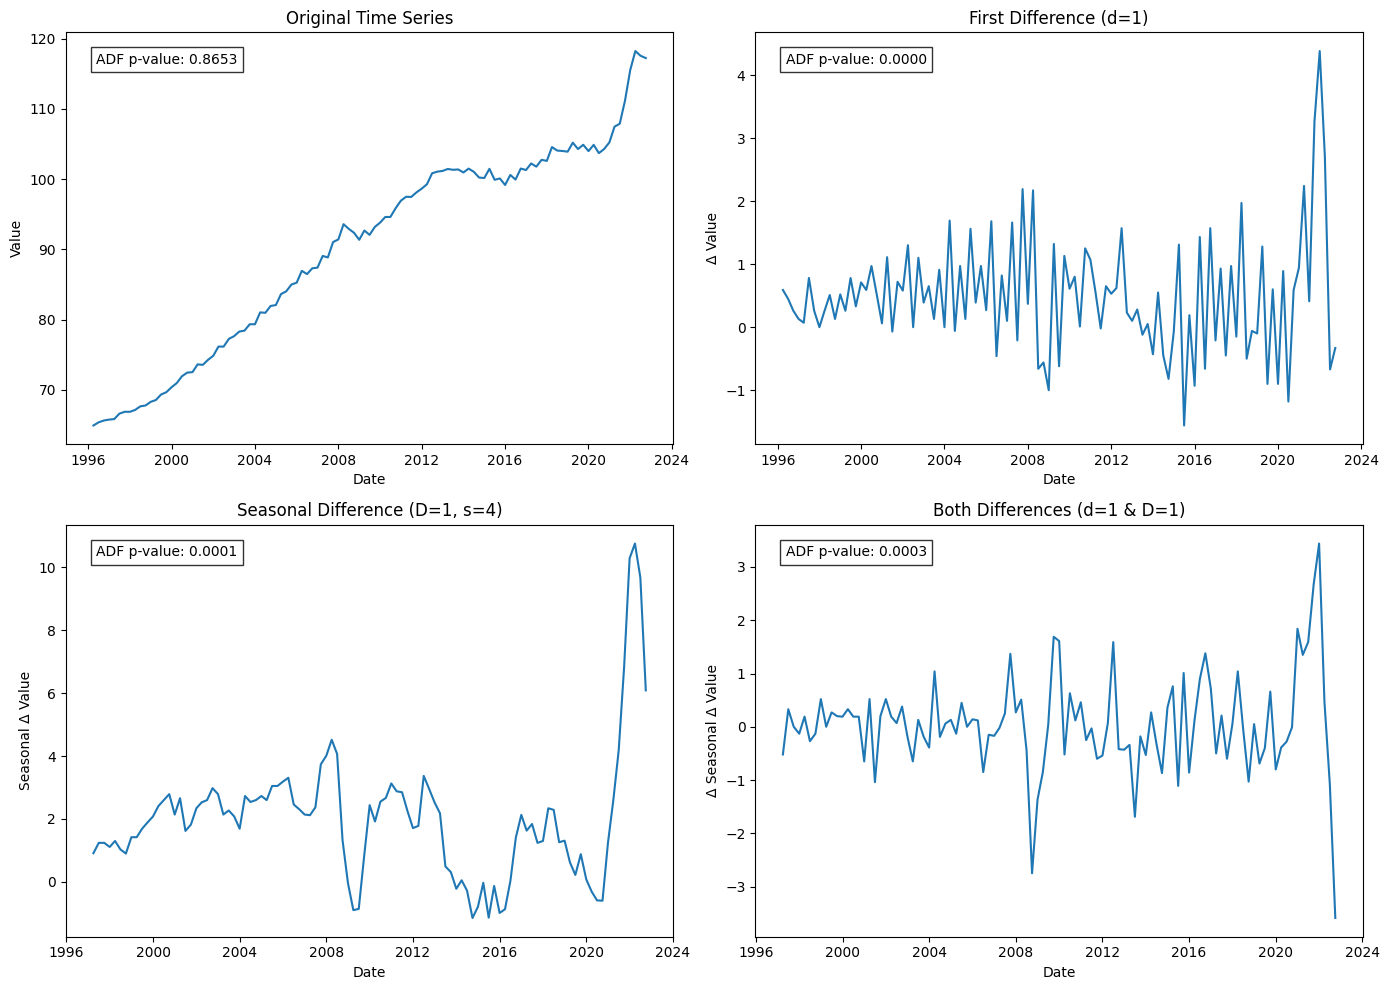

In [36]:
adf_original = adfuller(df["HICP.All.Spain"].dropna())
p_value_original = adf_original[1]

adf_diff = adfuller(df["HICP_diff"])
p_value_diff = adf_diff[1]

adf_seasonal = adfuller(seasonal_diff)
p_value_seasonal = adf_seasonal[1]

adf_both = adfuller(both_diff)
p_value_both = adf_both[1]

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Top-Left: Original time series with ADF p-value annotation
axs[0, 0].plot(df["HICP.All.Spain"], linestyle='-')
axs[0, 0].set_title("Original Time Series")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Value")
axs[0, 0].text(0.05, 0.95, f"ADF p-value: {p_value_original:.4f}",
               transform=axs[0, 0].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

# Top-Right: First Difference (non-seasonal) with ADF p-value annotation
axs[0, 1].plot(df["HICP_diff"], linestyle='-')
axs[0, 1].set_title("First Difference (d=1)")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Δ Value")
axs[0, 1].text(0.05, 0.95, f"ADF p-value: {p_value_diff:.4f}",
               transform=axs[0, 1].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

# Bottom-Left: Seasonal Difference (assumed seasonal period s=4) with ADF p-value annotation
axs[1, 0].plot(seasonal_diff, linestyle='-')
axs[1, 0].set_title("Seasonal Difference (D=1, s=4)")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Seasonal Δ Value")
axs[1, 0].text(0.05, 0.95, f"ADF p-value: {p_value_seasonal:.4f}",
               transform=axs[1, 0].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

# Bottom-Right: Both Differences (non-seasonal then seasonal) with ADF p-value annotation
axs[1, 1].plot(both_diff,  linestyle='-')
axs[1, 1].set_title("Both Differences (d=1 & D=1)")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Δ Seasonal Δ Value")
axs[1, 1].text(0.05, 0.95, f"ADF p-value: {p_value_both:.4f}",
               transform=axs[1, 1].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

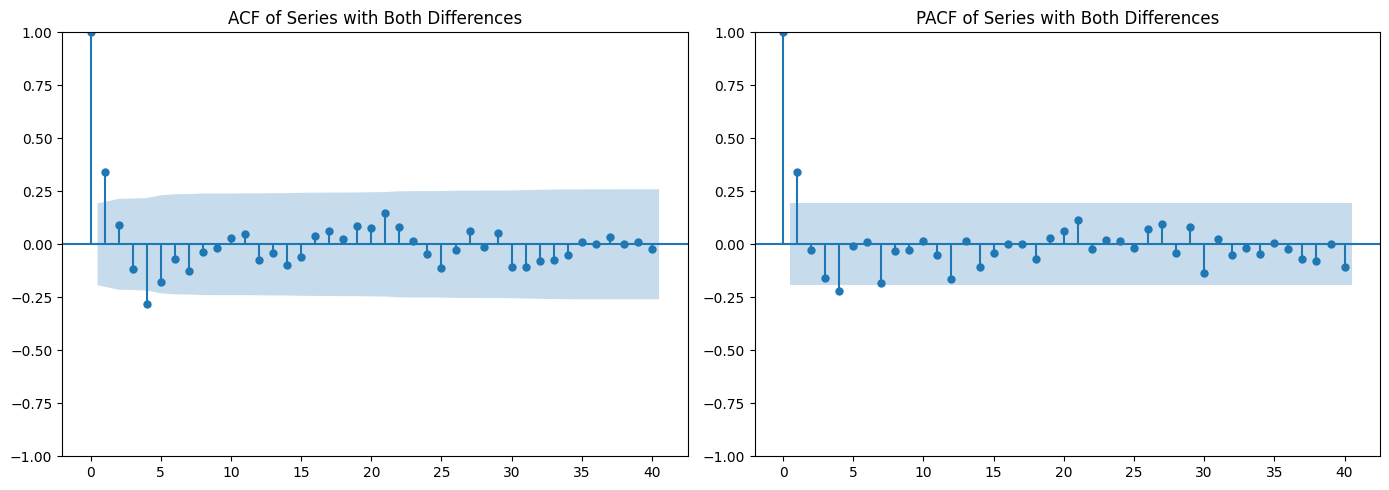

In [37]:
# Create ACF and PACF plots for the series with both differences
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot
sm.graphics.tsa.plot_acf(both_diff, lags=40, ax=axs[0])
axs[0].set_title("ACF of Series with Both Differences")

# PACF Plot
sm.graphics.tsa.plot_pacf(both_diff, lags=40, ax=axs[1], method='ywm')
axs[1].set_title("PACF of Series with Both Differences")

plt.tight_layout()
plt.show()

Not white noises

In [38]:
# Define the grid for non-seasonal parameters p, q and seasonal parameters P, Q
p_values = range(3)
q_values = range(3)
P_values = range(3)
Q_values = range(3)

# Fixed differencing orders and seasonal period
d = 1
D = 0
s = 4

# List to store results
results_list = []

# Grid search over all combinations of p, q, P, Q
for p, q, P, Q in itertools.product(p_values, q_values, P_values, Q_values):
    order = (p, d, q)
    seasonal_order = (P, D, Q, s)
    try:
        model = sm.tsa.SARIMAX(df["HICP.All.Spain"], order=order, seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        results_list.append({
            'p': p, 'd': d, 'q': q,
            'P': P, 'D': D, 'Q': Q, 's': s,
            'AIC': result.aic, 'BIC': result.bic
        })
    except Exception as e:
        # In case the model fails to fit, record NaN for AIC and BIC.
        results_list.append({
            'p': p, 'd': d, 'q': q,
            'P': P, 'D': D, 'Q': Q, 's': s,
            'AIC': np.nan, 'BIC': np.nan
        })

# Convert the list of results into a DataFrame and sort by BIC (or AIC)
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='BIC')
print(results_df)

# Find the row with the minimum AIC
best_aic_row = results_df.loc[results_df['AIC'].idxmin()]
# Find the row with the minimum BIC
best_bic_row = results_df.loc[results_df['BIC'].idxmin()]

print("Model with the lowest AIC:")
print(best_aic_row)

print("\nModel with the lowest BIC:")
print(best_bic_row)

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting pa

    p  d  q  P  D  Q  s         AIC         BIC
49  1  1  2  1  0  1  4  246.004725  261.985360
75  2  1  2  1  0  0  4  248.221091  264.201725
67  2  1  1  1  0  1  4  248.457799  264.438433
31  1  1  0  1  0  1  4  253.826469  264.480225
30  1  1  0  1  0  0  4  256.696722  264.687039
.. .. .. .. .. .. .. ..         ...         ...
36  1  1  1  0  0  0  4  292.879090  300.869407
18  0  1  2  0  0  0  4  293.930674  301.920991
27  1  1  0  0  0  0  4  308.433347  313.760226
0   0  1  0  0  0  0  4  311.291342  313.954781
9   0  1  1  0  0  0  4  310.879835  316.206713

[81 rows x 9 columns]
Model with the lowest AIC:
p        1.000000
d        1.000000
q        2.000000
P        1.000000
D        0.000000
Q        1.000000
s        4.000000
AIC    246.004725
BIC    261.985360
Name: 49, dtype: float64

Model with the lowest BIC:
p        1.000000
d        1.000000
q        2.000000
P        1.000000
D        0.000000
Q        1.000000
s        4.000000
AIC    246.004725
BIC    261.9853

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Extract best row

In [39]:
p = int(best_bic_row['p'])
d = int(best_bic_row['d'])
q = int(best_bic_row['q'])
P = int(best_bic_row['P'])
D = int(best_bic_row['D'])
Q = int(best_bic_row['Q'])
s = int(best_bic_row['s'])

# Refit the best SARIMA model on the series
best_model = sm.tsa.SARIMAX(df["HICP.All.Spain"], order=(p, d, q), seasonal_order=(P, D, Q, s))
best_result = best_model.fit(disp=False)

# Print the model summary to the console
print(best_result.summary())

                                      SARIMAX Results                                      
Dep. Variable:                      HICP.All.Spain   No. Observations:                  107
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 4)   Log Likelihood                -117.002
Date:                             Wed, 05 Mar 2025   AIC                            246.005
Time:                                     18:13:53   BIC                            261.985
Sample:                                 04-01-1996   HQIC                           252.482
                                      - 10-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8928      0.074    -12.067      0.000      -1.038      -0.748
ma.L1          1.2918      

All coefficient are statistically significant, no significant autocorrelation in the residuals, the model is structured well.

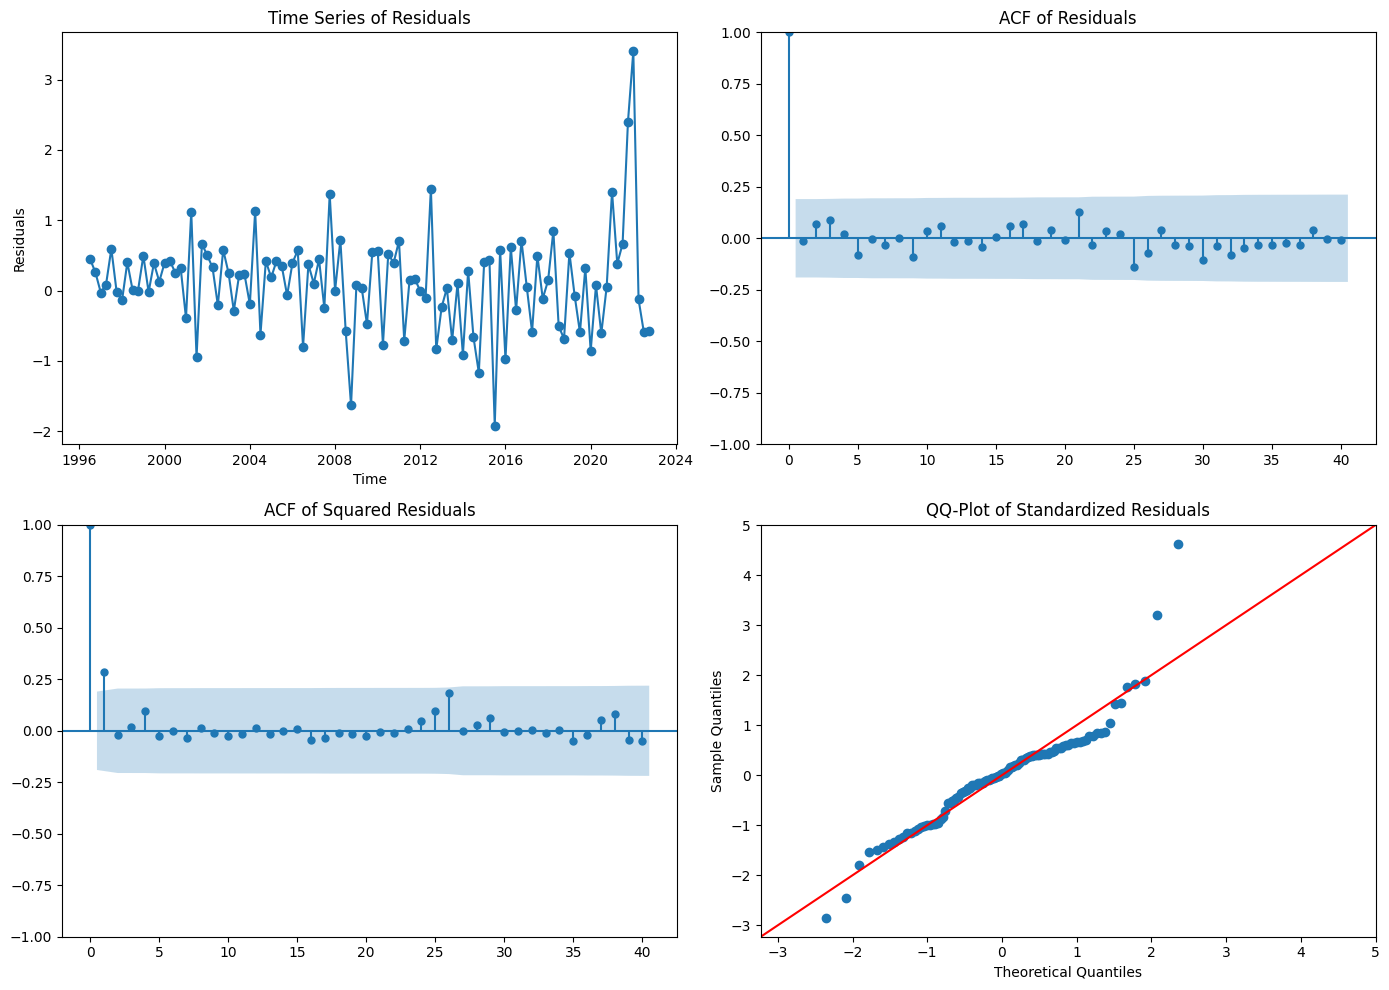

In [40]:
resid = best_result.resid
resid_sq = resid ** 2

# Elimate the first observation
resid_trimmed = resid.iloc[1:]
resid_sq_trimmed = resid_trimmed ** 2

# Standardised residuals
resid_std_trimmed = (resid_trimmed - resid_trimmed.mean()) / resid_trimmed.std()


fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Time Series of Residuals
axs[0, 0].plot(resid_trimmed, marker='o', linestyle='-')
axs[0, 0].set_title("Time Series of Residuals")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Residuals")

# ACF of Residuals
sm.graphics.tsa.plot_acf(resid_trimmed, lags=40, ax=axs[0, 1])
axs[0, 1].set_title("ACF of Residuals")

# ACF of Squared Residuals
sm.graphics.tsa.plot_acf(resid_sq_trimmed, lags=40, ax=axs[1, 0])
axs[1, 0].set_title("ACF of Squared Residuals")

# QQ-Plot of Standardized Residuals
sm.qqplot(resid_std_trimmed, line='45', ax=axs[1, 1])
axs[1, 1].set_title("QQ-Plot of Standardized Residuals")

plt.tight_layout()
plt.show()

In [41]:
train = df[df.index < '2015-01-01']
train = train.drop(columns=["Date"])
test = df[df.index >= '2015-01-01']
test = test.drop(columns=["Date"])

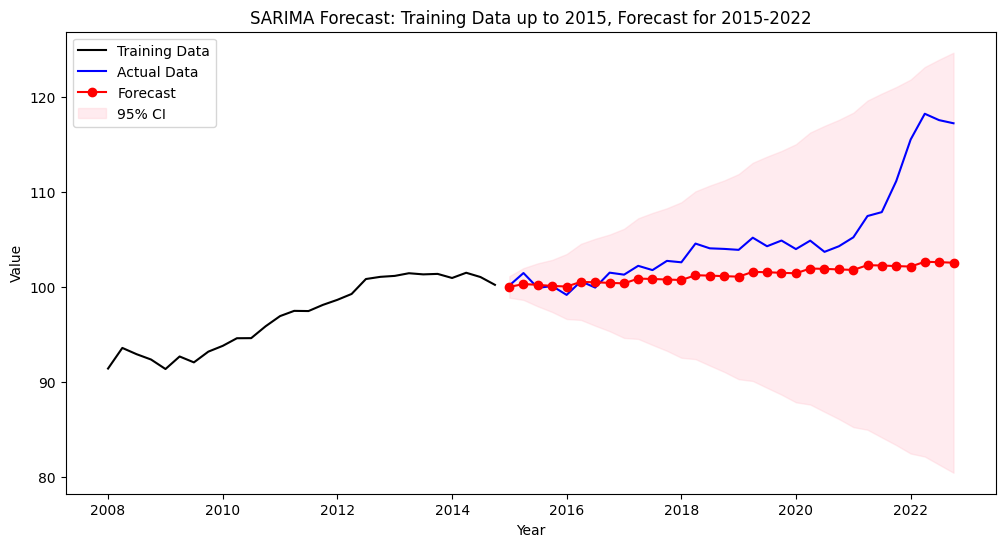

In [42]:
# 3. Fit the chosen SARIMA model on the training set
order = (p, d, q)
seasonal_order = (P, 1, Q, s)
model = sm.tsa.SARIMAX(train.iloc[:, 0], order=order, seasonal_order=seasonal_order)
result = model.fit()


forecast_result = result.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# 5. Plot the training data, test data, and forecast.

plt.figure(figsize=(12, 6))
train_subset = train[train.index >= '2008-01-01']
plt.plot(train_subset.index, train_subset.iloc[:, 0], label="Training Data", color='black')
# Plot test (actual) data
plt.plot(test.index, test.iloc[:, 0], label="Actual Data", color='blue')
# Plot forecasted values
plt.plot(test.index, forecast_mean, label="Forecast", color='red', marker='o')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color="pink", alpha=0.3, label="95% CI")
plt.title("SARIMA Forecast: Training Data up to 2015, Forecast for 2015-2022")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()

plt.show()


The model did not fully anticipate the sharp increase in recent years, suggesting an unexpected external factor might have driven the surge.

The SARIMA model predicts a stable, slightly increasing trend. However, the forecast remains significantly below actual values, indicating the model struggles to capture the acceleration in growth after 2019.

Since SARIMA does not incorporate exogenous variables, it cannot adjust for external factors (e.g., economic policies, inflation spikes, global events).

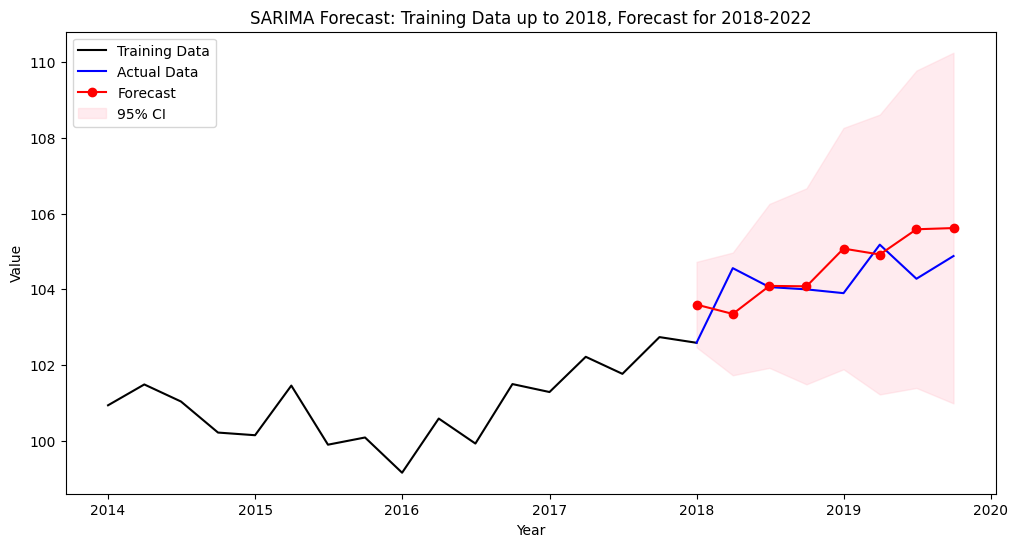

In [43]:
train = df[df.index <= '2018-01-01']
train = train.drop(columns=["Date"])
test = df[(df.index >= '2018-01-01')&(df.index<'2020-01-01')]
test = test.drop(columns=["Date"])

order = (p, d, q)
seasonal_order = (P, 1, Q, s)
model = sm.tsa.SARIMAX(train.iloc[:, 0], order=order, seasonal_order=seasonal_order)
result = model.fit()


forecast_result = result.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# 5. Plot the training data, test data, and forecast.

plt.figure(figsize=(12, 6))
train_subset = train[train.index >= '2014-01-01']
plt.plot(train_subset.index, train_subset.iloc[:, 0], label="Training Data", color='black')
# Plot test (actual) data
plt.plot(test.index, test.iloc[:, 0], label="Actual Data", color='blue')
# Plot forecasted values
plt.plot(test.index, forecast_mean, label="Forecast", color='red', marker='o')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color="pink", alpha=0.3, label="95% CI")
plt.title("SARIMA Forecast: Training Data up to 2018, Forecast for 2018-2022")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()

plt.show()


This SARIMA model was trained using data up to 2018, incorporating three additional years of training compared to the previous model. The forecasted values better align with the actual data compared to earlier predictions.

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Drop missing values if necessary
df_clean = df.dropna()

# Filter the dataset to train till 2020
train_data = df_clean.loc[:"2020"]  # Use only 2012-2020 for training

# Set forecast start (beginning of 2020) and extend to 2025
forecast_start = pd.to_datetime("2020-01-01")  # Start forecast from 2020
forecast_end = pd.to_datetime("2021-12-01")  # Forecast until end of 2025
test_data = df_clean.loc[forecast_start:forecast_end]  # Use available data for testing

# Train SARIMA model on 2012-2020 data
model = sm.tsa.SARIMAX(train_data['HICP.All.Spain'], order=(1,1,2), seasonal_order=(1, 0, 1, 4))
result = model.fit()

# Forecast from 2020 to 2025
forecast_values = result.get_forecast(steps=len(test_data))  

# Convert forecasted values to a Pandas Series with the correct index
forecast_series = pd.Series(forecast_values.predicted_mean.values, index=test_data.index)

# Evaluate Forecast Accuracy
mae = mean_absolute_error(test_data["HICP.All.Spain"], forecast_series)
rmse = np.sqrt(mean_squared_error(test_data["HICP.All.Spain"], forecast_series))
mape = np.mean(np.abs((test_data["HICP.All.Spain"] - forecast_series) / test_data["HICP.All.Spain"])) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 1.75
Root Mean Squared Error (RMSE): 2.68
Mean Absolute Percentage Error (MAPE): 1.61%


## Discoveries from SARIMA
The SARIMA model was trained using data up to 2018 and forecasted values for 2018-2020, incorporating both seasonality and trend components. While SARIMA provided an improvement over ARIMA, the MAPE of 1.61% suggests that the model aligns with the actual data and only deviates 1.61% from it.

Compared to the ARIMA model, SARIMA better follows the actual data fluctuations by incorporating seasonal patterns. The confidence interval widens over time, reflecting growing uncertainty in future forecasts.

## Out of Sample forecasting using SARIMA

/var/folders/qw/zy6hh4gn3636nhytvp50x6r80000gn/T/ipykernel_34548/1431386004.py:22: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start="2019-10-01", periods=forecast_steps, freq="Q")  # Quarterly data


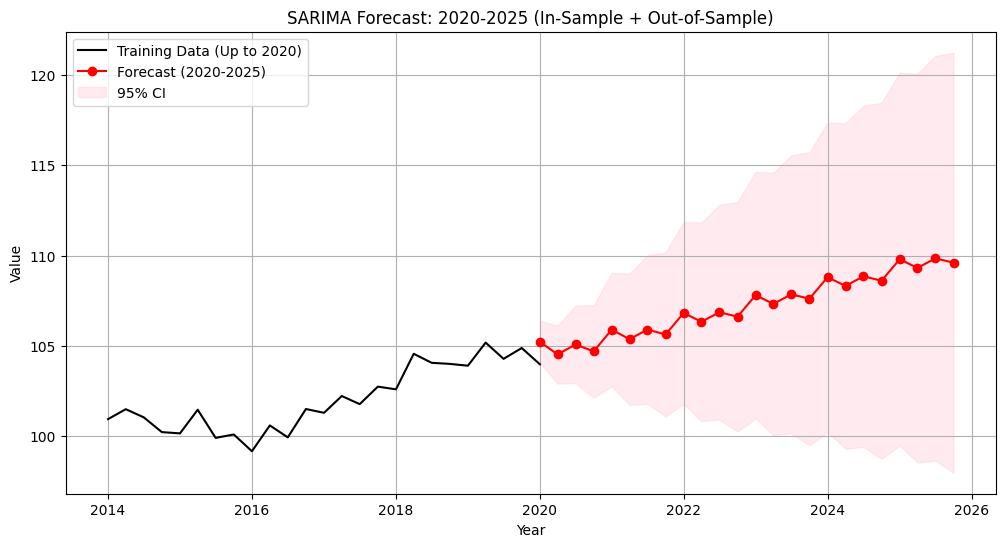

In [45]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Prepare Training Data (Use Data Until 2020)
train = df[df.index <= '2020-01-01'].drop(columns=["Date"])  # Training up to 2020

# 2. Define & Fit SARIMA Model
order = (p, d, q)
seasonal_order = (P, 1, Q, s)  # Keeping D=1 for seasonality

model = sm.tsa.SARIMAX(train.iloc[:, 0], order=order, seasonal_order=seasonal_order)
result = model.fit()

# 3. Generate Forecasts from 2020 to 2025
forecast_steps = 24  # 6 years * 4 quarters per year
forecast_result = result.get_forecast(steps=forecast_steps)  
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# 4. Create Future Index (2020-2025) for Forecast
future_dates = pd.date_range(start="2019-10-01", periods=forecast_steps, freq="Q")  # Quarterly data

# 5. Plot Training Data and Forecasts
plt.figure(figsize=(12, 6))

train_subset = train[train.index >= '2014-01-01']
plt.plot(train_subset.index, train_subset.iloc[:, 0], label="Training Data (Up to 2020)", color='black')

# Plot forecasted values (2020-2025)
plt.plot(future_dates, forecast_mean, label="Forecast (2020-2025)", color='red', marker='o')

# Plot confidence interval
plt.fill_between(future_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], 
                 color="pink", alpha=0.3, label="95% CI")

# Formatting
plt.title("SARIMA Forecast: 2020-2025 (In-Sample + Out-of-Sample)")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.grid()

plt.show()

### Conclusion from the Out-sample forecast
This SARIMA-based forecast models the expected trajectory of the Harmonized Index of Consumer Prices (HICP) under the assumption that COVID-19 never occurred. The model was trained on pre-2020 data, capturing historical trends and seasonal patterns, and projects future values for 2020-2025.

- Gradual and stable growth with no sudden disruptions
- No external shocks reflected in Forecast.This suggests that, without COVID-19, HICP would have experienced moderate inflationary pressure rather than extreme volatility
- Increasing Forecast Uncertainty as the confidence interval widens over time.However, the overall trend remains consistent with past patterns, meaning inflation would have followed its pre-pandemic path.

Without COVID-19, the HICP forecast suggests a stable and predictable inflation trajectory from 2020 to 2025. The model does not account for pandemic-driven economic shocks, such as global supply chain disruptions, government stimulus effects, or post-pandemic inflation surges. As a result, this forecast represents an alternative scenario where inflation remained under control, following historical trends.
